<a href="https://colab.research.google.com/github/2303A52486/Wallet-Risk-Scoring/blob/main/Wallet_Risk_Scoring_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wallet Risk Scoring Pipeline

This notebook computes normalized creditworthiness scores (0–1000) for Ethereum wallets based on Compound V2 on-chain activity.


In [5]:
import pandas as pd
import re

wallets_df = pd.read_csv('/content/Wallet id.csv')


print("Sample wallets:")
print(wallets_df.head())

# Validate Ethereum addresses
def is_valid_eth_address(addr):
    return bool(re.fullmatch(r"0x[a-fA-F0-9]{40}", addr))

wallets_df['is_valid'] = wallets_df['wallet_id'].apply(is_valid_eth_address)
print(f"\nValid wallets: {wallets_df['is_valid'].sum()} / {len(wallets_df)}")

valid_wallets = wallets_df[wallets_df['is_valid']].reset_index(drop=True)

valid_wallets.to_csv('valid_wallets.csv', index=False)

Sample wallets:
                                    wallet_id
0  0x0039f22efb07a647557c7c5d17854cfd6d489ef3
1  0x06b51c6882b27cb05e712185531c1f74996dd988
2  0x0795732aacc448030ef374374eaae57d2965c16c
3  0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9
4  0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae

Valid wallets: 103 / 103


In [6]:
ETHERSCAN_API_KEY = '###############################'

In [7]:
import requests

def fetch_normal_transactions(address, api_key, start_block=0, end_block=99999999):
    url = (
        f'https://api.etherscan.io/api?module=account&action=txlist&address={address}'
        f'&startblock={start_block}&endblock={end_block}&sort=asc&apikey={api_key}'
    )
    response = requests.get(url)
    data = response.json()
    if data['status'] == '1':
        return data['result']
    else:
        print(f"Error: {data['message']}")
        return []

# testing: First wallet
test_wallet = valid_wallets['wallet_id'][0]
transactions = fetch_normal_transactions(test_wallet, ETHERSCAN_API_KEY)

print(f"Fetched {len(transactions)} transactions for wallet: {test_wallet}")
if len(transactions) > 0:
    print("Sample TX:", transactions[0])

Fetched 1946 transactions for wallet: 0x0039f22efb07a647557c7c5d17854cfd6d489ef3
Sample TX: {'blockNumber': '3606695', 'timeStamp': '1493254201', 'hash': '0x9da9da95c9c48d82a818d60e13c14981264bb8b8418befbac79ec519595ff9d7', 'nonce': '289758', 'blockHash': '0x3933a1503dfd71252ed989c8137cd888dc6f460a0eeeeed10e54a1620f79ed55', 'transactionIndex': '37', 'from': '0x32be343b94f860124dc4fee278fdcbd38c102d88', 'to': '0x0039f22efb07a647557c7c5d17854cfd6d489ef3', 'value': '200000000000000000', 'gas': '333333', 'gasPrice': '30000000000', 'isError': '0', 'txreceipt_status': '', 'input': '0x', 'contractAddress': '', 'cumulativeGasUsed': '962090', 'gasUsed': '21000', 'confirmations': '19396866', 'methodId': '0x', 'functionName': ''}


In [8]:
compound_addresses = {
    'comptroller': '0x3d9819210a31b4961b30ef54be2aed79b9c9cd3b',
    'cETH': '0x4ddc2d193948926d02f9b1fe9e1daa0718270ed5',
    'cDAI': '0x5d3a536e4d6dbd6114cc1ead35777bab948e3643',
    'cUSDC': '0x39aa39c021dfbae8fac545936693ac917d5e7563'
}

compound_addresses_lower = set([addr.lower() for addr in compound_addresses.values()])

def filter_compound_transactions(tx_list):
    return [tx for tx in tx_list if tx['to'] and tx['to'].lower() in compound_addresses_lower]

compound_txs = filter_compound_transactions(transactions)
print(f"Compound-related transactions found: {len(compound_txs)}")

if compound_txs:
    print("Sample Compound TX:", compound_txs[0])

Compound-related transactions found: 22
Sample Compound TX: {'blockNumber': '8472545', 'timeStamp': '1567451347', 'hash': '0x1c61798644a09960097e8d16570248b3e899e5437ca3ef15febcf67a10a4017d', 'nonce': '696', 'blockHash': '0x671c321d574442aa6d5201f10248038051b0fcadf74438105e53b6dea20b5d40', 'transactionIndex': '24', 'from': '0x0039f22efb07a647557c7c5d17854cfd6d489ef3', 'to': '0x3d9819210a31b4961b30ef54be2aed79b9c9cd3b', 'value': '0', 'gas': '450000', 'gasPrice': '2100000000', 'isError': '0', 'txreceipt_status': '1', 'input': '0xc2998238000000000000000000000000000000000000000000000000000000000000002000000000000000000000000000000000000000000000000000000000000000070000000000000000000000006c8c6b02e7b2be14d4fa6022dfd6d75921d90e4e000000000000000000000000f5dce57282a584d2746faf1593d3121fcac444dc0000000000000000000000004ddc2d193948926d02f9b1fe9e1daa0718270ed5000000000000000000000000158079ee67fce2f58472a96584a73c7ab9ac95c100000000000000000000000039aa39c021dfbae8fac545936693ac917d5e756300000000000

In [10]:
from datetime import datetime
from collections import Counter

def extract_wallet_features(compound_txs, wallet_address):
    borrow_count = 0
    repay_count = 0
    enter_markets_count = 0
    interacted_ctokens = set()
    error_tx_count = 0
    total_gas_used = 0
    timestamps = []

    for tx in compound_txs:
        input_sig = tx['input'][:10]
        to_addr = tx['to'].lower()
        timestamps.append(int(tx['timeStamp']))
        total_gas_used += int(tx.get('gasUsed', 0))
        if tx.get('isError') == '1':
            error_tx_count += 1

        # to Recognize Compound methods
        if input_sig == '0xc2998238':  # enterMarkets
            enter_markets_count += 1
        elif input_sig == '0xc5ebeaec':  # borrow(uint256)
            borrow_count += 1
        elif input_sig == '0x0e752702':  # repayBorrow(uint256)
            repay_count += 1

        interacted_ctokens.add(to_addr)

    first_activity_days_ago = (datetime.utcnow() - datetime.utcfromtimestamp(min(timestamps))).days if timestamps else None

    return {
        'wallet_id': wallet_address,
        'compound_tx_count': len(compound_txs),
        'borrow_count': borrow_count,
        'repay_count': repay_count,
        'enter_markets_count': enter_markets_count,
        'unique_ctokens': len(interacted_ctokens),
        'error_tx_count': error_tx_count,
        'gas_used': total_gas_used,
        'first_activity_days_ago': first_activity_days_ago
    }

# feature extraction
features = extract_wallet_features(compound_txs, test_wallet)
print("Extracted features for wallet:")
print(features)

Extracted features for wallet:
{'wallet_id': '0x0039f22efb07a647557c7c5d17854cfd6d489ef3', 'compound_tx_count': 22, 'borrow_count': 1, 'repay_count': 1, 'enter_markets_count': 1, 'unique_ctokens': 4, 'error_tx_count': 0, 'gas_used': 5067951, 'first_activity_days_ago': 2153}


In [28]:
import time

all_wallet_features = []

def fetch_normal_transactions_with_retry(address, api_key, retries=3):
    for attempt in range(retries):
        txs = fetch_normal_transactions(address, api_key)
        if txs: return txs
        print(f"⏳ Retry {attempt + 1} for wallet {address}...")
        time.sleep(2)
    return []

for wallet in valid_wallets['wallet_id']:
    try:
        txs = fetch_normal_transactions_with_retry(wallet, ETHERSCAN_API_KEY)
        compound_txs = filter_compound_transactions(txs)
        features = extract_wallet_features(compound_txs, wallet)
        all_wallet_features.append(features)
        print(f"{wallet} - {features['compound_tx_count']} compound txs")

        time.sleep(2)
    except Exception as e:
        print(f" Failed to process {wallet}: {e}")

features_df = pd.DataFrame(all_wallet_features)
features_df.to_csv('wallet_features.csv', index=False)

print("\n All features extracted and saved to wallet_features.csv")

0x0039f22efb07a647557c7c5d17854cfd6d489ef3 - 22 compound txs
0x06b51c6882b27cb05e712185531c1f74996dd988 - 1 compound txs
0x0795732aacc448030ef374374eaae57d2965c16c - 1 compound txs
0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9 - 1 compound txs
0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae - 1 compound txs
0x104ae61d8d487ad689969a17807ddc338b445416 - 1 compound txs
0x111c7208a7e2af345d36b6d4aace8740d61a3078 - 2 compound txs
0x124853fecb522c57d9bd5c21231058696ca6d596 - 3 compound txs
0x13b1c8b0e696aff8b4fee742119b549b605f3cbc - 1 compound txs
0x1656f1886c5ab634ac19568cd571bc72f385fdf7 - 0 compound txs
0x1724e16cb8d0e2aa4d08035bc6b5c56b680a3b22 - 0 compound txs
0x19df3e87f73c4aaf4809295561465b993e102668 - 1 compound txs
0x1ab2ccad4fc97c9968ea87d4435326715be32872 - 1 compound txs
0x1c1b30ca93ef57452d53885d97a74f61daf2bf4f - 10 compound txs
0x1e43dacdcf863676a6bec8f7d6896d6252fac669 - 1 compound txs
0x22d7510588d90ed5a87e0f838391aaafa707c34b - 0 compound txs
0x24b3460622d835c56d9a4fe352966b9bdc6c

                                    wallet_id  compound_tx_count  \
0  0x0039f22efb07a647557c7c5d17854cfd6d489ef3                 22   
1  0x06b51c6882b27cb05e712185531c1f74996dd988                  1   
2  0x0795732aacc448030ef374374eaae57d2965c16c                  1   
3  0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9                  1   
4  0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae                  1   

   borrow_count  repay_count  enter_markets_count  unique_ctokens  \
0             1            1                    1               4   
1             0            0                    0               1   
2             0            0                    0               1   
3             0            0                    0               1   
4             0            0                    0               1   

   error_tx_count  gas_used  first_activity_days_ago  
0               0   5067951                   2153.0  
1               0    174552                   1744.0  
2          

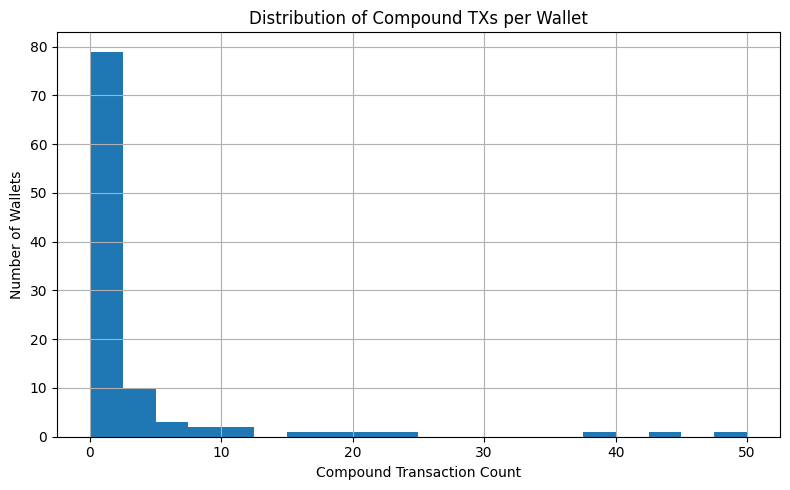

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/wallet_features.csv')

# Preview
print(df.head())
print("\nColumns:", df.columns.tolist())
print("\nTX Count Summary:\n", df['compound_tx_count'].describe())

# Count of wallets with 0, 1, 2, ... compound transactions
print("\nDistribution:\n", df['compound_tx_count'].value_counts().sort_index())

# histogram plot
plt.figure(figsize=(8, 5))
df['compound_tx_count'].hist(bins=20)
plt.xlabel("Compound Transaction Count")
plt.ylabel("Number of Wallets")
plt.title("Distribution of Compound TXs per Wallet")
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# dataset
df = pd.read_csv('/content/wallet_features.csv')

# Select the relevant numerical features to normalize
features_to_normalize = [
    'compound_tx_count',
    'borrow_count',
    'repay_count',
    'enter_markets_count',
    'unique_ctokens',
    'error_tx_count',
    'gas_used',
    'first_activity_days_ago'
]

# initialize the scaler
scaler = MinMaxScaler()

# Normalize the features and to create a new DataFrame
normalized_values = scaler.fit_transform(df[features_to_normalize])
normalized_df = pd.DataFrame(normalized_values, columns=[f + '_norm' for f in features_to_normalize])

# Concatenate the normalized columns with original wallet_id
result_df = pd.concat([df[['wallet_id']], normalized_df], axis=1)

# Preview the normalized result
print(result_df.head())

# Save the normalized file
result_df.to_csv('/content/normalized_wallet_features.csv', index=False)

                                    wallet_id  compound_tx_count_norm  \
0  0x0039f22efb07a647557c7c5d17854cfd6d489ef3                    0.44   
1  0x06b51c6882b27cb05e712185531c1f74996dd988                    0.02   
2  0x0795732aacc448030ef374374eaae57d2965c16c                    0.02   
3  0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9                    0.02   
4  0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae                    0.02   

   borrow_count_norm  repay_count_norm  enter_markets_count_norm  \
0           0.142857               0.2                  0.111111   
1           0.000000               0.0                  0.000000   
2           0.000000               0.0                  0.000000   
3           0.000000               0.0                  0.000000   
4           0.000000               0.0                  0.000000   

   unique_ctokens_norm  error_tx_count_norm  gas_used_norm  \
0                 1.00                  0.0       0.373504   
1                 0.25      

In [20]:
# Load normalized wallet features
df = pd.read_csv("/content/normalized_wallet_features.csv")
df.head()

,wallet_id,compound_tx_count_norm,borrow_count_norm,repay_count_norm,enter_markets_count_norm,unique_ctokens_norm,error_tx_count_norm,gas_used_norm,first_activity_days_ago_norm
0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0.44,0.142857,0.2,0.111111,1.00,0.0,0.373504,0.959811
1,0x06b51c6882b27cb05e712185531c1f74996dd988,0.02,0.000000,0.0,0.000000,0.25,0.0,0.012864,0.476359
2,0x0795732aacc448030ef374374eaae57d2965c16c,0.02,0.000000,0.0,0.000000,0.25,0.0,0.013090,0.429078
3,0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9,0.02,0.000000,0.0,0.000000,0.25,0.0,0.012862,0.408983
4,0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae,0.02,0.000000,0.0,0.000000,0.25,0.0,0.012864,0.470449


In [25]:
# Define weights for normalized features (weights should sum to ~1 or close)
weights = {
    'compound_tx_count_norm': 0.2,
    'borrow_count_norm': 0.2,
    'repay_count_norm': 0.15,
    'enter_markets_count_norm': 0.1,
    'unique_ctokens_norm': 0.1,
    'error_tx_count_norm': -0.05,  # penalizing risky behavior
    'gas_used_norm': 0.1,
    'first_activity_days_ago_norm': 0.1,
}

# Ensuring all required columns exist
missing_cols = [col for col in weights if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required normalized columns: {missing_cols}")

# Calculate raw risk score
df['risk_score_raw'] = sum(df[col] * wt for col, wt in weights.items())

# Min and max for normalization
min_score = df['risk_score_raw'].min()
max_score = df['risk_score_raw'].max()

# Handle division by zero
if min_score == max_score:
    df['risk_score'] = 500  # or any constant fallback score
else:
    df['risk_score'] = ((df['risk_score_raw'] - min_score) / (max_score - min_score)) * 1000

# Fill any remaining NaNs (safety net)
df['risk_score'] = df['risk_score'].fillna(0)

# Round and convert
df['risk_score'] = df['risk_score'].round().astype(int)

# Preview
df[['wallet_id', 'risk_score']].head()

,wallet_id,risk_score
0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,432
1,0x06b51c6882b27cb05e712185531c1f74996dd988,51
2,0x0795732aacc448030ef374374eaae57d2965c16c,46
3,0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9,43
4,0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae,51


In [27]:
df[['wallet_id', 'risk_score']].to_csv('wallet_risk_scores.csv', index=False)
from google.colab import files
files.download('wallet_risk_scores.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>